In [ ]:
!pip install numpy matplotlib tensorflow librosa scikit-learn opencv-python ultralytics pillow pandas requests tqdm

  Using cached ultralytics-8.4.7-py3-none-any.whl.metadata (38 kB)
  Using cached torchvision-0.25.0-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached polars-1.37.1-py3-none-any.whl.metadata (10 kB)
  Using cached ultralytics_thop-2.0.18-py3-none-any.whl.metadata (14 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.24.1-cp311-cp311-win_amd64.whl.metadata (5.9 kB)
Using cached ultralytics-8.4.7-py3-none-any.whl (1.2 MB)
Using cached polars-1.37.1-py3-none-any.whl (805 kB)
Using cached torchvision-0.24.1-cp311-cp311-win_amd64.whl (4.0 MB)
Using cached ultralytics_thop-2.0.18-py3-none-any.whl (28 kB)

   ---------------------------------------- 0/4 [polars]
   ---------------------------------------- 0/4 [polars]
   ---------------------------------------- 0/4 [polars]
   ---------------------------------------- 0/4 [polars]
   ----------------------

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import cv2
from ultralytics import YOLO
import warnings
from PIL import Image
import os
import requests
import zipfile
from tqdm import tqdm
import pandas as pd
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\rafki\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


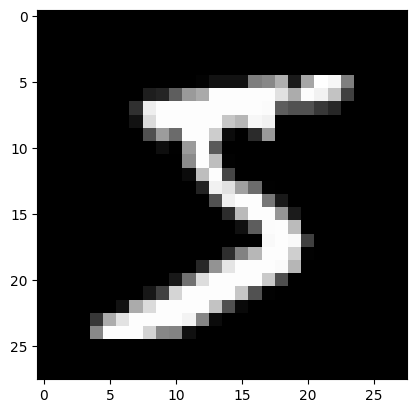

In [4]:
plt.imshow(x_train[0], cmap='gray')

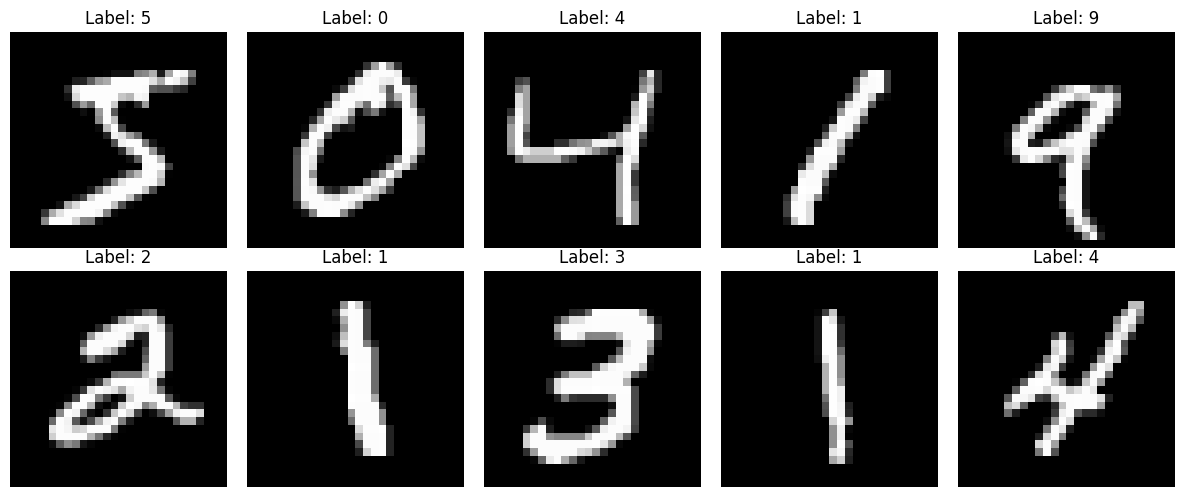

Pixel value range: 0 - 255


In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Pixel value range: {x_train.min()} - {x_train.max()}")

In [6]:
x_train_processed = x_train.astype('float32') / 255.0
x_test_processed = x_test.astype('float32') / 255.0

x_train_processed = np.expand_dims(x_train_processed, -1)
x_test_processed = np.expand_dims(x_test_processed, -1)

print(f"Processed training shape: {x_train_processed.shape}")
print(f"Pixel value range after normalization: {x_train_processed.min()} - {x_train_processed.max()}")

Processed training shape: (60000, 28, 28, 1)
Pixel value range after normalization: 0.0 - 1.0


In [7]:
model_image = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)), # 28*28 -> 26*26*32
    layers.MaxPooling2D((2, 2)), # 26*26*32 -> 13*13*32
    layers.Conv2D(64, (3, 3), activation='relu'), # 13*13*32 -> 11*11*64
    layers.MaxPooling2D((2, 2)), # 11*11*64 -> 5*5*64
    layers.Conv2D(64, (3, 3), activation='relu'), # 5*5*64 -> 3*3*64
    layers.Flatten(), # 3*3*64 -> 576
    layers.Dense(64, activation='relu'), # 576 -> 64
    layers.Dense(10, activation='softmax') # 64 -> 10
])

model_image.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_image.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model_image.fit(x_train_processed, y_train,
                          epochs=5,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=1)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9261 - loss: 0.2512 - val_accuracy: 0.9845 - val_loss: 0.0587
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9821 - loss: 0.0589 - val_accuracy: 0.9883 - val_loss: 0.0409
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9878 - loss: 0.0402 - val_accuracy: 0.9885 - val_loss: 0.0403
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9891 - loss: 0.0341 - val_accuracy: 0.9913 - val_loss: 0.0326
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9913 - loss: 0.0272 - val_accuracy: 0.9908 - val_loss: 0.0361


Test accuracy: 0.9914


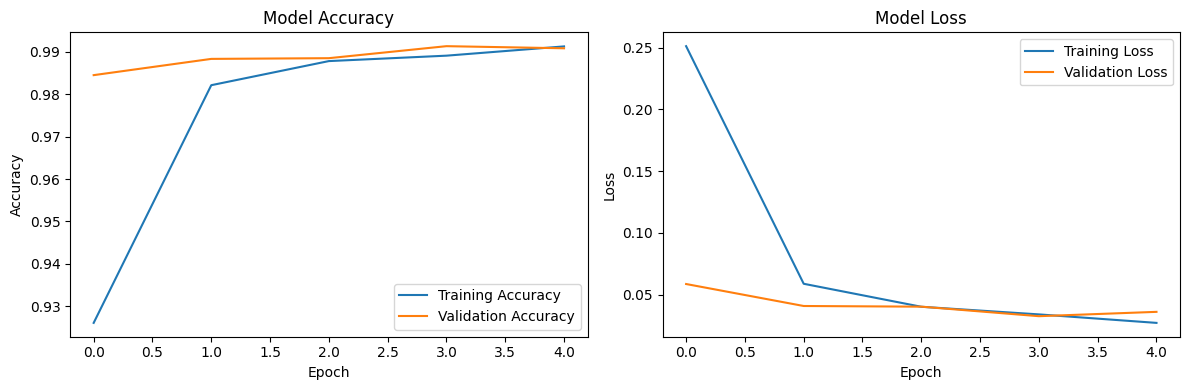

In [9]:
test_loss, test_acc = model_image.evaluate(x_test_processed, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


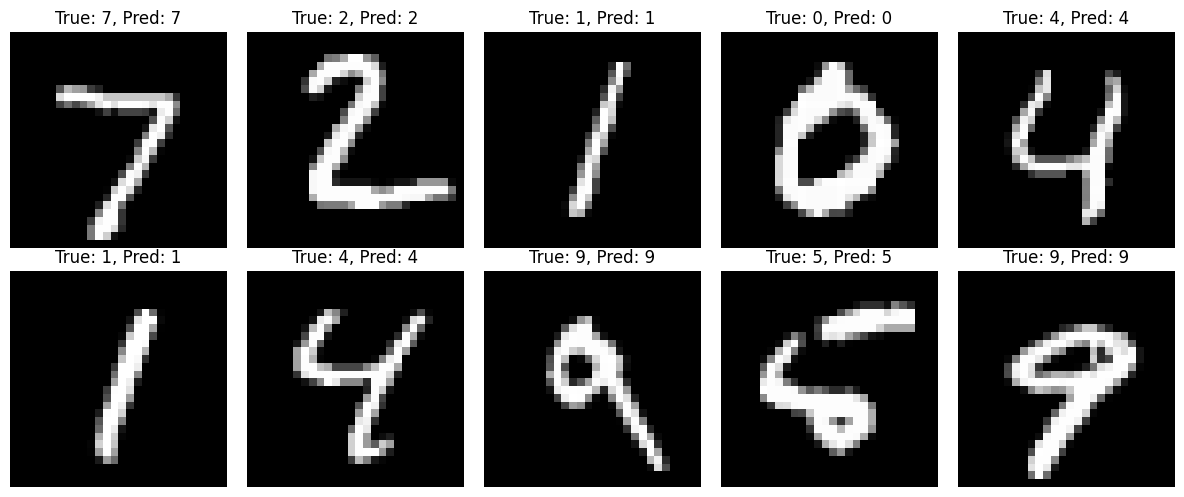

In [10]:
predictions = model_image.predict(x_test_processed[:10])
predicted_labels = np.argmax(predictions, axis=1)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i], cmap='gray')
    ax.set_title(f"True: {y_test[i]}, Pred: {predicted_labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
import numpy as np
import tkinter as tk
from PIL import Image, ImageDraw

size = 28
scale = 10

img = Image.new("L", (size, size), 0)
draw = ImageDraw.Draw(img)

root = tk.Tk()
root.title("Handwritten Input")

canvas = tk.Canvas(root, width=size*scale, height=size*scale, bg="black")
canvas.pack()

def paint(event):
    x = event.x // scale
    y = event.y // scale
    if 0 <= x < size and 0 <= y < size:
        draw.rectangle([x, y, x+1, y+1], fill=255)
        canvas.create_rectangle(
            x*scale, y*scale, (x+1)*scale, (y+1)*scale,
            fill="white", outline="white"
        )

def predict():
    x = np.array(img, dtype=np.float32)
    x = x[None, ..., None]
    preds = model_image.predict(x)
    print("Predicted:", np.argmax(preds))

def clear():
    draw.rectangle([0, 0, size, size], fill=0)
    canvas.delete("all")

canvas.bind("<B1-Motion>", paint)

tk.Button(root, text="Predict", command=predict).pack()
tk.Button(root, text="Clear", command=clear).pack()

root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Predicted: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted: 4
